# Imports

## Common

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import random_split, Dataset, DataLoader, ConcatDataset, Subset
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

from IPython.display import clear_output

## TF

In [ ]:
"""
Adapted from https://colab.research.google.com/github/google-research/simclr/blob/master/colabs/finetuning.ipynb
"""

import numpy as np

import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import tensorflow_hub as hub
from sklearn.linear_model import LogisticRegression
import os



## HuggingFace

In [ ]:
!pip install datasets
!pip install transformers
!pip install timm

import transformers
import datasets

clear_output()

## Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Utilities

## Analytical Gaussian Mechanism

In [ ]:
#Analytical Gaussian Mechanism (taken from https://github.com/BorjaBalle/analytic-gaussian-mechanism/blob/master/agm-example.py)
from math import exp, sqrt
from scipy.special import erf

def cagm(epsilon, delta, GS, tol = 1.e-12):
    """ Calibrate a Gaussian perturbation for differential privacy using the analytic Gaussian mechanism of [Balle and Wang, ICML'18]

    Arguments:
    epsilon : target epsilon (epsilon > 0)
    delta : target delta (0 < delta < 1)
    GS : upper bound on L2 global sensitivity (GS >= 0)
    tol : error tolerance for binary search (tol > 0)

    Output:
    sigma : standard deviation of Gaussian noise needed to achieve (epsilon,delta)-DP under global sensitivity GS
    """

    def Phi(t):
        return 0.5*(1.0 + erf(float(t)/sqrt(2.0)))

    def caseA(epsilon,s):
        return Phi(sqrt(epsilon*s)) - exp(epsilon)*Phi(-sqrt(epsilon*(s+2.0)))

    def caseB(epsilon,s):
        return Phi(-sqrt(epsilon*s)) - exp(epsilon)*Phi(-sqrt(epsilon*(s+2.0)))

    def doubling_trick(predicate_stop, s_inf, s_sup):
        while(not predicate_stop(s_sup)):
            s_inf = s_sup
            s_sup = 2.0*s_inf
        return s_inf, s_sup

    def binary_search(predicate_stop, predicate_left, s_inf, s_sup):
        s_mid = s_inf + (s_sup-s_inf)/2.0
        while(not predicate_stop(s_mid)):
            if (predicate_left(s_mid)):
                s_sup = s_mid
            else:
                s_inf = s_mid
            s_mid = s_inf + (s_sup-s_inf)/2.0
        return s_mid

    delta_thr = caseA(epsilon, 0.0)

    if (delta == delta_thr):
        alpha = 1.0

    else:
        if (delta > delta_thr):
            predicate_stop_DT = lambda s : caseA(epsilon, s) >= delta
            function_s_to_delta = lambda s : caseA(epsilon, s)
            predicate_left_BS = lambda s : function_s_to_delta(s) > delta
            function_s_to_alpha = lambda s : sqrt(1.0 + s/2.0) - sqrt(s/2.0)

        else:
            predicate_stop_DT = lambda s : caseB(epsilon, s) <= delta
            function_s_to_delta = lambda s : caseB(epsilon, s)
            predicate_left_BS = lambda s : function_s_to_delta(s) < delta
            function_s_to_alpha = lambda s : sqrt(1.0 + s/2.0) + sqrt(s/2.0)

        predicate_stop_BS = lambda s : abs(function_s_to_delta(s) - delta) <= tol

        s_inf, s_sup = doubling_trick(predicate_stop_DT, 0.0, 1.0)
        s_final = binary_search(predicate_stop_BS, predicate_left_BS, s_inf, s_sup)
        alpha = function_s_to_alpha(s_final)

    sigma = alpha*GS/sqrt(2.0*epsilon)

    return sigma



## DP Normalized Centroids Model

In [ ]:
#Sum!
from sklearn.preprocessing import normalize

class DP_CentroidClassifier():
  def __init__(self, epsilon = 1, delta=0.01):

    self.centroids = None
    self.classes = None
    self.epsilon = epsilon
    self.delta = delta
    self.vars = None


  def fit(self, X_train, y_train, normalization = True):
    self.classes = np.unique(y_train)
    centroids = []

    for c in self.classes:
      centroids.append(np.mean(X_train[y_train == c], axis=0))

    self.centroids = np.array(centroids)

    if normalization:
      self.centroids = normalize(centroids)


  def dp_fit(self, X_train, y_train, denoise = None, amplification = None, normalization = True, debug = False):

    self.classes = np.unique(y_train)
    centroids = []
    sigmas = []

    # possible privacy amplification
    if amplification != None:
        X_sampled, y_sampled = self.privacy_amplification(amplification, X_train, y_train)
        X_train = X_sampled
        y_train = y_sampled

    X_train_clipped = normalize(X_train)

    #no feature normalization
    if debug:
      X_train_clipped = X_train

    #calculate noise
    sigma = cagm(self.epsilon, self.delta, 1)


    for c in self.classes:
        class_samples_count = X_train_clipped[y_train == c].shape[0]
        #calculate sum
        class_centroid = np.sum(X_train_clipped[y_train == c], axis=0)

        #perturb class mean
        noisy_class_centroid = self.perturb_features(class_centroid, sigma)
        centroids.append(noisy_class_centroid)


    self.centroids = np.array(centroids)
    if normalization:
      self.centroids = normalize(self.centroids)


  def predict_proba(self, X_test):
    n_samples = X_test.shape[0]
    y_test_probs = np.zeros((n_samples, len(self.classes)))


    for i in range(n_samples):
        #calculate distance from centroids
        dists = np.linalg.norm(X_test[i,:] - self.centroids, axis = 1)

        #use softmax to transform dists to probabilities
        from scipy.special import softmax
        y_test_probs[i,:] = 1 - softmax(dists)

    return y_test_probs



  def predict(self, X_test, dist='l2'):

    n_samples = X_test.shape[0]
    y_test = np.zeros(n_samples)

    for i in range(n_samples):
        if dist == 'l2':
            #calculate distance from centroids
            dists = np.linalg.norm(X_test[i,:] - self.centroids, axis = 1)

        elif dist == 'dot':
            dists = -X_test[i,:]@(self.centroids.T)

        y_test[i] = self.classes[np.argmin(dists)]

    return y_test


  def score(self, X_test, y_test, dist = 'l2'):

    predictions = self.predict(X_test, dist=dist)
    predictions = predictions.reshape(y_test.shape[0])
    return (np.sum(predictions == y_test.reshape(y_test.shape[0]))/y_test.shape[0])


  def calculate_entropy(self, X):

    from scipy.stats import entropy
    centroids = self.centroids
    classes = self.classes


    probs = self.predict_proba(X)
    ents = entropy(probs, axis=1)

    return ents


  def perturb_features(self, X_train, sigma, private_labels = False):

    #add noise
    X_noisy = X_train + sigma*np.random.standard_normal(X_train.shape)

    return X_noisy


  def privacy_amplification(self, q, X, y):
    X_sampled = []
    y_sampled = []

    for c in self.classes:
        X_class_sampled, y_class_sampled = self.per_class_privacy_amplification(q,
                                                     X[y == c], y[y == c])
        X_sampled.append(X_class_sampled)
        y_sampled.append(y_class_sampled)

    X_sampled = np.concatenate(X_sampled)
    y_sampled = np.concatenate(y_sampled)

    return X_sampled, y_sampled

  def per_class_privacy_amplification(self, q, X, y):
    n_samples = X.shape[0]
    sampled_indices = np.random.binomial(1, q, n_samples)
    return X[sampled_indices == 1], y[sampled_indices == 1]

## Deep Models

In [ ]:
class ModelExperiment():
  def __init__(self, model_name = 'dino_vitb16'):
    self.model_name = model_name
    self.models = dict()

    self.download()

  def download(self):
    models = dict()

    match self.model_name:

      # Vision Models
      case 'resnet50':
        models['model'] = torchvision.models.resnet50(weights = 'DEFAULT')

      case 'resnet152':
        models['model'] = torchvision.models.resnet152(weights = 'DEFAULT')

      case 'dino_vitb16':
        models['model'] = transformers.ViTModel.from_pretrained('facebook/dino-vitb16')

      case 'msn_vitb16':
        models['model'] = transformers.ViTMSNModel.from_pretrained('facebook/vit-msn-base')


      # NLP Models
      case 'data2vec':
        hf_path = 'facebook/data2vec-text-base'
        models['autotokenizer'] = transformers.AutoTokenizer.from_pretrained(hf_path)
        models['model'] = transformers.AutoModel.from_pretrained(hf_path)

      case 'unsup_simcse_roberta_base':
        hf_path = 'princeton-nlp/unsup-simcse-roberta-base'
        models['autotokenizer'] = transformers.AutoTokenizer.from_pretrained(hf_path)
        models['model'] = transformers.AutoModel.from_pretrained(hf_path)

      case 'unsup_simcse_roberta_large':
        hf_path = 'princeton-nlp/unsup-simcse-roberta-large'
        models['autotokenizer'] = transformers.AutoTokenizer.from_pretrained(hf_path)
        models['model'] = transformers.AutoModel.from_pretrained(hf_path)

      case 'sup_simcse_roberta_base':
        hf_path = 'princeton-nlp/sup-simcse-roberta-base'
        models['autotokenizer'] = transformers.AutoTokenizer.from_pretrained(hf_path)
        models['model'] = transformers.AutoModel.from_pretrained(hf_path)

      case 'sup_simcse_roberta_large':
        hf_path = 'princeton-nlp/sup-simcse-roberta-large'
        models['autotokenizer'] = transformers.AutoTokenizer.from_pretrained(hf_path)
        models['model'] = transformers.AutoModel.from_pretrained(hf_path)

      case 'sup_simcse_bert_base':
        hf_path = 'princeton-nlp/sup-simcse-bert-large-uncased'
        models['autotokenizer'] = transformers.AutoTokenizer.from_pretrained(hf_path)
        models['model'] = transformers.AutoModel.from_pretrained(hf_path)

      case 'sup_simcse_bert_large':
        hf_path = 'princeton-nlp/sup-simcse-bert-large-uncased'
        models['autotokenizer'] = transformers.AutoTokenizer.from_pretrained(hf_path)
        models['model'] = transformers.AutoModel.from_pretrained(hf_path)

      case other:
        print('Model identifier not found!, possible models: ')
        print(self.get_default_models())

    self.models = models

  def get_model(self):
    return self.models


  def get_default_models(self):
    default_models = dict()
    vision_models = ['dino', 'msn', 'resnet (152, 50)', 'simclrv2']
    nlp_models = ['data2vec', 'simcse sup roberta large, base', 'simcse unsup roberta large, base', 'simcse sup bert large, base']
    default_models['vision'] = vision_models
    default_models['nlp'] = nlp_models
    return default_models



## Datasets

In [ ]:
from torchvision import datasets, transforms

class DatasetExperiment():
  def __init__(self, name = 'cifar10_torch', task_name = None, preprocessing_args = dict()):
    self.name = name
    self.task_name = task_name
    self.class_descriptions = None

    self.transform = self.create_transform(preprocessing_args)
    self.download()


  def download(self):
    # pytorch
    match self.name:
      case 'cifar10_torch':
        self.train_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=self.transform)
        self.test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
                                              download=True, transform=self.transform)

        self.classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

      # simclrv2
      case 'cifar10_tf':
        (xtrain, ytrain), (xtest, ytest) = tf.keras.datasets.cifar10.load_data()
        xtrain = xtrain.astype(np.float32) / 255.0
        xtest = xtest.astype(np.float32) / 255.0
        y_train = ytrain.reshape(-1)
        y_test = ytest.reshape(-1)


      # huggingface nlp data
      case 'glue':
        task = self.task_name
        dataset = datasets.load_dataset('glue', task)
        train_dataset = dataset['train']
        test_dataset = dataset['validation']
        train_dataset.set_format(type = 'torch')
        test_dataset.set_format(type = 'torch')


      case other:
        print('Dataset identifier not found!')


  # preprocess data
  # -- preprocessing arguments --
  # type : 'imagenet' (normal without resize), 'imagenet_resize' (normal with resize for transformers)
  # size : 224 for vit-b/16 transformers
  def create_transform(self, preprocessing_args = dict()):
    transform = None

    # TODO
    if 'type' in preprocessing_args.keys():
      preprocessing_type = preprocessing_args['type']

    match preprocessing_type:
      # normal
      case 'imagenet':
        transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.2, 0.2, 0.2))])

      # transformer
      case 'imagenet_resize':
        size = preprocessing_args['resize_size']

        transform = transforms.Compose(
            [transforms.Resize(size),
                transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.2, 0.2, 0.2))])

      ## TODO
      case 'imagenet_simclr':
        pass

      case 'glue'
        pass

      case other:
        print('Preprocessing pipeline identifier not found!')

    return transform



  # return dataloaders for train and test data.
  # -- dataloader args --
  # batch_size
  def get_dataloaders(self, dataloader_args = dict()):
    train_dataloader = DataLoader(self.train_data, **dataloader_args)
    test_dataloader = DataLoader(self.test_data, **dataloader_args)

    return train_dataloader, test_dataloader




# stores features
def store_features(features, root, experiment_identifier = '_'):
  for key in features.keys():
    path = root + experiment_identifier + key
    np.save(path, features[key])


# loads features as a dictionary
def load_features(root, experiment_identifier, keys):
  features = dict()
  parent_path = root + experiment_identifier

  for key in keys:
    path = parent_path + key + ".npy"
    features[key] = np.load(path)

  return features

### SimCLR Preprocessin

In [ ]:

# preprocessing functions for SimCLR


## Feature Extraction

In [ ]:
from tqdm import tqdm

class ImageFeatureExtractor_Torch():
  def __init__(self, model, model_name):
    self.model = model
    self.model_name = model_name

    # a dict to store the activations
    self.activation = None
    self.hook = None


  # extract features
  def extract(self, dataloader, device):

    # possibly register hook. the function checks model name to make sure a hook is needed
    self.register_hook()


    # initializations
    X, y = [], []
    self.model.eval()

    # feature extraction loop
    with torch.no_grad():
      # train features
      print("###Extracting features###")
      for i, (input, target) in enumerate(tqdm(dataloader)):

        outputs = self.model(input.to(device))
        embeddings = self.get_embeddings(outputs)
        X.append(embeddings.cpu().numpy())
        y.append(target.cpu().numpy())

    print("Done")


    # numpyify the features!
    X = np.concatenate(X)
    y = np.concatenate(y)

    if self.hook:
      self.hook.remove()

    return X, y


  # TODO
  # get embeddings using outputs and the registered hook
  def get_embeddings(self, outputs):

    if self.model_name == 'dino_vitb16':
      ## DINO ViTb16
      embeddings = outputs.last_hidden_state[:,0]


    elif self.model_name == 'msn':
      embeddings = outputs.last_hidden_states[:,0]

    ## xcit
    # last_hidden_states = outputs

    else:
      pass

    return embeddings



  # torch method for restoring activations
  def getActivation(self, name):
    self.activation = dict()
    # the hook signature
    def hook(model, input, output):
      self.activation[name] = output.detach()
    return hook


  # register hook
  def register_hook(self):
    if self.model_name == 'dino_vitb16':
      return

    if self.model_name == 'msn':
      return

    elif self.model_name == 'resnet50':
      final_embedding_layer = model.classifier[0]
    ## xcit
    # last_hidden_states = outputs

    else:
      return

    # register forward hooks on the final embedding layer
    self.hook = final_embedding_layer.register_forward_hook(self.getActivation('feats'))






  class SentenceClassificationFeatureExtractor_HF():
    def __init__(self, model, model_name, tokenizer):
      self.model = model
      self.model_name = model_name
      self.tokenizer = tokenizer
      self.embedding_type = None

      match model_name:
        case 'simcse_roberta':
          self.embedding_type = 'last_hidden_states'
        case other:
          print('model name not defined')
          return

    def extract(self, dataloader, device, dataset_name, task_name):
      # find correct keys to access text features using dataset and task name
      input_id, output_id, idx_id = None, None, None

      match dataset_name:
        case 'glue':

          match task_name:
            case 'sst2':
              input_id = 'sentence'
              output_id = 'label'
              idx_id = 'idx'

            case other:
              print('task identifier not found')
              return

        case other:
          print('dataset identifier not found')
          return


      X, y, idx = [], [], []
      dataloader_iterable = enumerate(tqdm(dataloader))

      self.model.eval()
      with torch.no_grad():
        print("Extracting embeddings!")

        for input, features in dataloader_iterable:
          idx.append((features[idx_id]).cpu().numpy())
          y.append(features[output_id].cpu().numpy())

          sentences = features[input_id]
          inputs = self.tokenizer(sentences, padding=True, truncation=True, return_tensors="pt").to(device)

          match self.embedding_type:
            case 'last_hidden_states':
              embeddings = self.model(**inputs, output_hidden_states=True, return_dict=True).last_hidden_state[:,0].to(device)

            case 'pooler_output':
              embeddings = model(**inputs, output_hidden_states=True, return_dict=True).pooler_output.to(device)

            case other:
              print('embedding type not defined')
              return

          X.append(embeddings.cpu().numpy())

      print('Done')
      return np.concatenate(X), np.concatenate(y), np.concatenate(idx)






## Evaluations

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm import tqdm

def accuracy_epsilon_sweep(dp_params = dict(), data = dict(), model_type = 'dp_normalized_centroids', dp_mechanism_args = dict()):
  delta = dp_params['delta']
  eps = dp_params['epsilons']
  accs = []

  # sweep epsilons
  for epsilon in tqdm(eps):

    # model
    if model_type == 'dp_normalized_centroids':
      X_train = data['X_train']
      X_test = data['X_test']
      y_train = data['y_train']
      y_test = data['y_test']

      dpc = DP_CentroidClassifier(epsilon = epsilon, delta = delta, **dp_mechanism_args)
      dpc.dp_fit(X_train, y_train)
      acc = dpc.score(X_test, y_test, dist = 'dot')

    # different privacy mechanisms?
    else:
      acc = 0

    accs.append(acc)

  return accs

def plot_epsilon_sweep(eps, accs, dataset_name = 'CIFAR-10', backbone_name = 'Dino ViT/16b'):
  plt.scatter(eps, accs)
  plt.title(f'{dataset_name} Accuracy With {backbone_name} Backbone')
  plt.xlabel('Epsilon')
  plt.ylabel('Accuracy')


# Experiments

## Dino

### model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = 'dino_vitb16'
model_dict = ModelExperiment(model_name = model_name).get_model()
model = model_dict['model']
model.to(device)

### data

In [ ]:
preprocessing_args = dict()
preprocessing_args['type'] = 'imagenet_resize'
preprocessing_args['resize_size'] = 224

dataloader_args = dict()
dataloader_args['batch_size'] = 32

dataset_name = 'cifar10_torch'

dataset = DatasetExperiment(name = dataset_name, preprocessing_args = preprocessing_args)
train_dataloader, test_dataloader = dataset.get_dataloaders(dataloader_args)

Files already downloaded and verified
Files already downloaded and verified


### feature extraction

In [ ]:
feature_extractor = ImageFeatureExtractor_Torch(model, model_name)

# get train embeddings
print('train dataset')
X_train, y_train = feature_extractor.extract(train_dataloader, device)

# get test embeddings
print('test dataset')
X_test, y_test = feature_extractor.extract(test_dataloader, device)

train dataset
###Extracting features###


100%|██████████| 1563/1563 [10:30<00:00,  2.48it/s]


Done
test dataset
###Extracting features###


100%|██████████| 313/313 [02:15<00:00,  2.31it/s]

Done


### evaluations

100%|██████████| 32/32 [00:09<00:00,  3.42it/s]


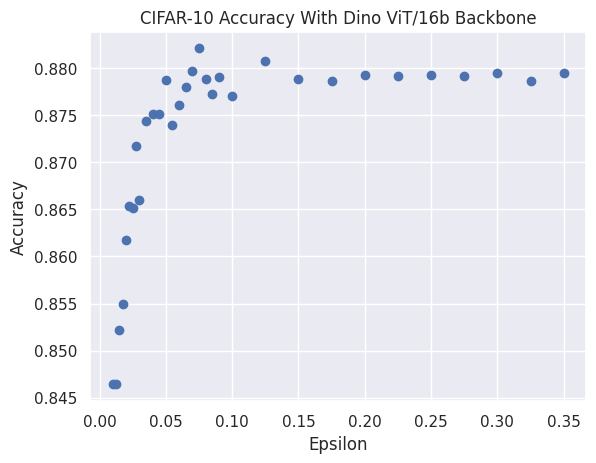

In [ ]:
data = dict()
data['X_train'] = X_train
data['X_test'] = X_test
data['y_train'] = y_train
data['y_test'] = y_test


eps =  [0.01, 0.0125, 0.015, 0.0175, 0.02, 0.0225, 0.025, 0.0275, 0.03, 0.035, 0.04,
        0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.1, 0.125, 0.15,
        0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35]

delta = 1/1000

dp_params = dict()
dp_params['delta'] = delta
dp_params['epsilons'] = eps

accs = accuracy_epsilon_sweep(dp_params, data, model_type = 'dp_normalized_centroids')

dataset_name = 'CIFAR-10'
backbone_name = 'Dino ViTb/16'
plot_epsilon_sweep(eps, accs, )
plt.show()

## MSN

## SimCSE

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = 'sup_simcse_roberta_large'
model_dict = ModelExperiment(model_name = model_name).get_model()
model = model_dict['model']
model.to(device)




RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 1024, padding_idx=1)
    (position_embeddings): Embedding(514, 1024, padding_idx=1)
    (token_type_embeddings): Embedding(1, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-23): 24 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      